In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
np.set_printoptions(precision=4, suppress=True, threshold=16)

Bagging meta-estimator(Bagging 元估计器)
---
在集成算法中，bagging 方法会在原始训练集的随机子集上构建一类黑盒估计器的多个实例，然后把这些估计器的预测结果结合起来形成最终的预测结果。 该方法通过在构建模型的过程中引入随机性，来减少基估计器的方差(例如，决策树)。 在多数情况下，bagging 方法提供了一种非常简单的方式来对单一模型进行改进，而无需修改背后的算法。 因为 bagging 方法可以减小过拟合，所以通常在强分类器和复杂模型上使用时表现的很好（例如，完全生长的决策树，fully developed decision trees），相比之下 boosting 方法则在弱模型上表现更好（例如，浅层决策树，shallow decision trees）。

bagging 方法有很多种，其主要区别在于随机抽取训练子集的方法不同：

- 如果抽取的数据集的随机子集是样例的随机子集，我们叫做粘贴 (Pasting) [B1999] 。
- 如果样例抽取是有放回的，我们称为 Bagging [B1996] 。
- 如果抽取的数据集的随机子集是特征的随机子集，我们叫做**随机子空间** (Random Subspaces) [H1998] 。
- 最后，如果基估计器构建在对于样本和特征抽取的子集之上时，我们叫做随机补丁 (Random Patches) [LG2012]。

在 scikit-learn 中，bagging 方法使用统一的`BaggingClassifier` 元估计器（或者 `BaggingRegressor` ），基估计器和随机子集抽取策略由用户指定。`max_samples` 和` max_features` 控制着子集的大小（对于样例和特征）， `bootstrap`和 `bootstrap_features `控制着样例和特征的抽取是有放回还是无放回的。 当使用样本子集时，通过设置 `oob_score=True `，可以使用袋外(out-of-bag)样本来评估泛化精度

[Single estimator versus bagging: bias-variance decomposition](https://scikit-learn.org/stable/auto_examples/ensemble/plot_bias_variance.html#sphx-glr-auto-examples-ensemble-plot-bias-variance-py)

In [3]:
# Settings
n_repeat = 50       # Number of iterations for computing expectations
n_train = 50        # Size of the training set
n_test = 1000       # Size of the test set
noise = 0.1         # Standard deviation of the noise
np.random.seed(0)

Automatically created module for IPython interactive environment
Tree: 0.0255 (error) = 0.0003 (bias^2)  + 0.0152 (var) + 0.0098 (noise)
Bagging(Tree): 0.0196 (error) = 0.0004 (bias^2)  + 0.0092 (var) + 0.0098 (noise)


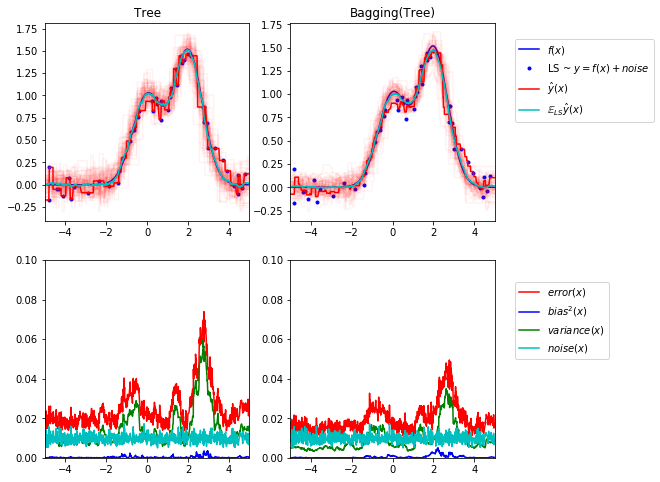

In [30]:
print(__doc__)

# Author: Gilles Louppe <g.louppe@gmail.com>
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# Settings
n_repeat = 50       # Number of iterations for computing expectations
n_train = 50        # Size of the training set
n_test = 1000       # Size of the test set
noise = 0.1         # Standard deviation of the noise
np.random.seed(0)

# Change this for exploring the bias-variance decomposition of other
# estimators. This should work well for estimators with high variance (e.g.,
# decision trees or KNN), but poorly for estimators with low variance (e.g.,
# linear models).
estimators = [("Tree", DecisionTreeRegressor()),  # 单一决策树回归
              ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor()))  # 多个决策树Bagging
             ]

n_estimators = len(estimators)


# Generate data
def f(x):
    x = x.ravel()

    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)


def generate(n_samples, noise, n_repeat=1):
    """
    生成数据
    X (-5, 5) 之间正态分布
    y = f(x) + noise
    repeat: 多个数据集 X相同 y不同
    """
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y


X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

# X_test (n_test, 1)  y_test (n_test, n_repeat) 同一个测试X, n_repeat种噪声 
# X_train (n_train, 1)* n_repeat  y_train (n_train,) * n_repeat
X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

plt.figure(figsize=(10, 8))

# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    # Compute predictions
    y_predict = np.zeros((n_test, n_repeat))
    
    # 每个学习器 X_train, y_train都不相同, 测试用的X_test相同 得到n_repeat个模型的预测结果
    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)
    
    # y_predict (n_test, n_repeat)
    
    # 偏差^2 + 方差 + 噪声 = MSE 均方根误差
    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.zeros(n_test)
    
    # MSE
    # y_error_i = \sum_{j=1}^{n_repeat} \sum_{k=1}^{n_repeat} (y_test[i, k] - y_predict[i, j])^2 
    for i in range(n_repeat):  
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2
    
    # 一个 样本点 计算了 n_repeat * n_repeat个error值
    y_error /= (n_repeat * n_repeat)
    
    # 相同x ,不同噪声生成的n_repeat种y
    y_noise = np.var(y_test, axis=1)
    
    # 偏差 预测值偏离实际值的值
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    
    # 多个模型预测值的方差
    y_var = np.var(y_predict, axis=1)

    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                      np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))

    # Plot figures
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$")

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label=r"$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c",
             label=r"$\mathbb{E}_{LS} \^y(x)$")

    plt.xlim([-5, 5])
    plt.title(name)

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")

    plt.xlim([-5, 5])
    plt.ylim([0, 0.1])

    if n == n_estimators - 1:

        plt.legend(loc=(1.1, .5))

plt.subplots_adjust(right=.75)
plt.show()

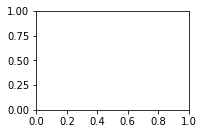

In [37]:
plt.subplot(2, 2, 1)